To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://unsloth.ai/docs/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://unsloth.ai/docs/get-started/install).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & how to save it

### News

Long-Context GRPO for reinforcement learning — train stably at massive sequence lengths. Fine-tune models with up to 7x more context length efficiently. [Read Blog](https://unsloth.ai/docs/new/grpo-long-context)

3× faster training with optimized sequence packing — higher throughput with no quality loss.[Read Blog](https://unsloth.ai/docs/new/3x-faster-training-packing)

500k context-length fine-tuning — push long-context models further with memory-efficient training. [Read Blog](https://unsloth.ai/docs/new/500k-context-length-fine-tuning)

Introducing FP8 precision training for faster RL inference. [Read Blog](https://unsloth.ai/docs/new/fp8-reinforcement-learning).

Unsloth's [Docker image](https://hub.docker.com/r/unsloth/unsloth) is here! Start training with no setup & environment issues. [Read our Guide](https://unsloth.ai/docs/new/how-to-train-llms-with-unsloth-and-docker).

Visit our docs for all our [model uploads](https://unsloth.ai/docs/get-started/all-our-models) and [notebooks](https://unsloth.ai/docs/get-started/unsloth-notebooks).

### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.0
!pip install --no-deps trl==0.26.2

### Unsloth

We're also introducing how you can do `GSPO` inside of Unsloth as well!

The goal of this notebook is to make a vision language model solve maths problems via reinforcement learning given an image input like below:

<img src="https://raw.githubusercontent.com/lupantech/MathVista/main/assets/our_new_3_datasets.png" alt="Alt text" height="256">

In [2]:
from unsloth import FastVisionModel
import torch
max_seq_length = 16384 # Must be this long for VLMs
lora_rank = 16 # Larger rank = smarter, but slower

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = False, # Enable vLLM fast inference
    gpu_memory_utilization = 0.8, # Reduce if out of memory
    # dtype=torch.float16
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.4: Fast Qwen3_Vl patching. Transformers: 4.57.0.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.32 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

In Unsloth, we share vLLM's weights directly, reducing VRAM usage by > 50%. vLLM also does not yet support LoRA on the vision layers, so we can only add them on the language layers. Vision GRPO still works though!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True,  # False if not finetuning language layers
    finetune_attention_modules = True,  # False if not finetuning attention layers
    finetune_mlp_modules       = True,  # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

### Data Prep
<a name="Data"></a>

`AI4Math/MathVista` is a dataset that involves using images to solve logic and math problems.

For this notebook, we will only use math problems with numeric answers for simplicity.

In [4]:
from datasets import load_dataset
from trl import GRPOConfig, GRPOTrainer

dataset = load_dataset("AI4Math/MathVista", split = "testmini")

README.md: 0.00B [00:00, ?B/s]

data/testmini-00000-of-00001-725687bf7a1(…):   0%|          | 0.00/142M [00:00<?, ?B/s]

data/test-00000-of-00002-6b81bd7f7e2065e(…):   0%|          | 0.00/358M [00:00<?, ?B/s]

data/test-00001-of-00002-6a611c71596db30(…):   0%|          | 0.00/386M [00:00<?, ?B/s]

Generating testmini split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5141 [00:00<?, ? examples/s]

We filter the dataset to keep only float or numeric answers:

In [5]:
def is_numeric_answer(example):
    try:
        float(example["answer"])
        return True
    except:
        return False

dataset = dataset.filter(is_numeric_answer)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

We also resize the images to be 512 by 512 pixels to make the images managable in context length. We also convert them to RGB so they are compatible for training!

In [6]:
# Resize to (512, 512)
def resize_images(example):
    image = example["decoded_image"]
    image = image.resize((512, 512))
    example["decoded_image"] = image
    return example
dataset = dataset.map(resize_images)

# Then convert to RGB
def convert_to_rgb(example):
    image = example["decoded_image"]
    if image.mode != "RGB":
        image = image.convert("RGB")
    example["decoded_image"] = image
    return example
dataset = dataset.map(convert_to_rgb)

Map:   0%|          | 0/566 [00:00<?, ? examples/s]

Map:   0%|          | 0/566 [00:00<?, ? examples/s]

We then create the conversational template that is needed to collate the dataset for RL:

In [7]:
# Define the delimiter variables for clarity and easy modification
REASONING_START = "<REASONING>"
REASONING_END = "</REASONING>"
SOLUTION_START = "<SOLUTION>"
SOLUTION_END = "</SOLUTION>"

def make_conversation(example):
    # Define placeholder constants if they are not defined globally
    # The user's text prompt
    text_content = (
        f"{example['question']}. Also first provide your reasoning or working out"\
        f" on how you would go about solving the question between {REASONING_START} and {REASONING_END}"
        f" and then your final answer between {SOLUTION_START} and (put a single float here) {SOLUTION_END}"
    )

    # Construct the prompt in the desired multi-modal format
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "image"},  # Placeholder for the image
                {"type": "text", "text": text_content},  # The text part of the prompt
            ],
        },
    ]
    # The actual image data is kept separate for the processor
    return {"prompt": prompt, "image": example["decoded_image"], "answer": example["answer"]}

train_dataset = dataset.map(make_conversation)

# We're reformatting dataset like this because decoded_images are the actual images
# The "image": example["decoded_image"] does not properly format the dataset correctly

# 1. Remove the original 'image' column
train_dataset = train_dataset.remove_columns("image")

# 2. Rename 'decoded_image' to 'image'
train_dataset = train_dataset.rename_column("decoded_image", "image")

Map:   0%|          | 0/566 [00:00<?, ? examples/s]

Now let's apply the chat template across the entire dataset:

## Reward functions

We now define some basic formatting rewards functions to see if reasoning starts and ends, and also another to see if the answers were written correctly.

We also try to fix the `addCriterion` issue as described in our [blog post](https://unsloth.ai/docs/new/vision-reinforcement-learning-vlm-rl#qwen-2.5-vl-vision-rl-issues-and-quirks)

In [8]:
# Reward functions
import re

def formatting_reward_func(completions,**kwargs):
    import re
    thinking_pattern = f'{REASONING_START}(.*?){REASONING_END}'
    answer_pattern = f'{SOLUTION_START}(.*?){SOLUTION_END}'

    scores = []
    for completion in completions:
        if isinstance(completion, list):
            completion = completion[0]["content"] if completion else ""
        score = 0
        thinking_matches = re.findall(thinking_pattern, completion, re.DOTALL)
        answer_matches = re.findall(answer_pattern, completion, re.DOTALL)
        if len(thinking_matches) == 1:
            score += 1.0
        if len(answer_matches) == 1:
            score += 1.0

        # Fix up addCriterion issues
        # See https://unsloth.ai/docs/new/vision-reinforcement-learning-vlm-rl#qwen-2.5-vl-vision-rl-issues-and-quirks
        # Penalize on excessive addCriterion and newlines
        if len(completion) != 0:
            removal = completion.replace("addCriterion", "").replace("\n", "")
            if (len(completion)-len(removal))/len(completion) >= 0.5:
                score -= 2.0

        scores.append(score)
    return scores


def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    answer_pattern = f'{SOLUTION_START}(.*?){SOLUTION_END}'

    completions = [(c[0]["content"] if c else "") if isinstance(c, list) else c for c in completions]
    responses = [re.findall(answer_pattern, completion, re.DOTALL) for completion in completions]
    q = prompts[0]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:{completions[0]}")
    return [
        2.0 if len(r)==1 and a == r[0].replace('\n','') else 0.0
        for r, a in zip(responses, answer)
    ]

Here is the first example prompt in the dataset

In [9]:
train_dataset[0]["prompt"]

[{'content': [{'text': None, 'type': 'image'},
   {'text': "When a spring does work on an object, we cannot find the work by simply multiplying the spring force by the object's displacement. The reason is that there is no one value for the force-it changes. However, we can split the displacement up into an infinite number of tiny parts and then approximate the force in each as being constant. Integration sums the work done in all those parts. Here we use the generic result of the integration.\r\n\r\nIn Figure, a cumin canister of mass $m=0.40 \\mathrm{~kg}$ slides across a horizontal frictionless counter with speed $v=0.50 \\mathrm{~m} / \\mathrm{s}$. It then runs into and compresses a spring of spring constant $k=750 \\mathrm{~N} / \\mathrm{m}$. When the canister is momentarily stopped by the spring, by what distance $d$ is the spring compressed?. Also first provide your reasoning or working out on how you would go about solving the question between <REASONING> and </REASONING> and th

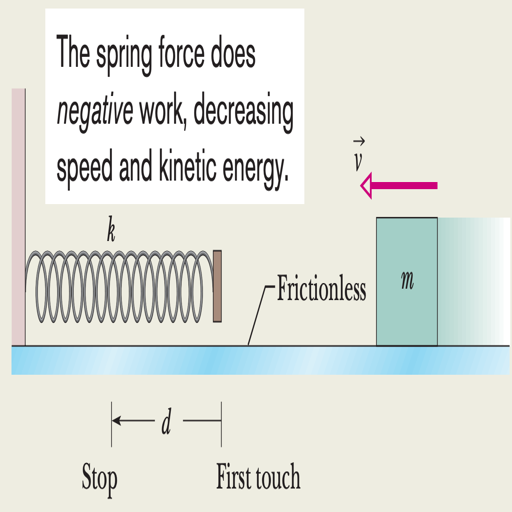

In [10]:
train_dataset[0]["image"]

In [11]:
train_dataset[100]["prompt"]

[{'content': [{'text': None, 'type': 'image'},
   {'text': 'Move the ruler to measure the length of the nail to the nearest inch. The nail is about (_) inches long.. Also first provide your reasoning or working out on how you would go about solving the question between <REASONING> and </REASONING> and then your final answer between <SOLUTION> and (put a single float here) </SOLUTION>',
    'type': 'text'}],
  'role': 'user'}]

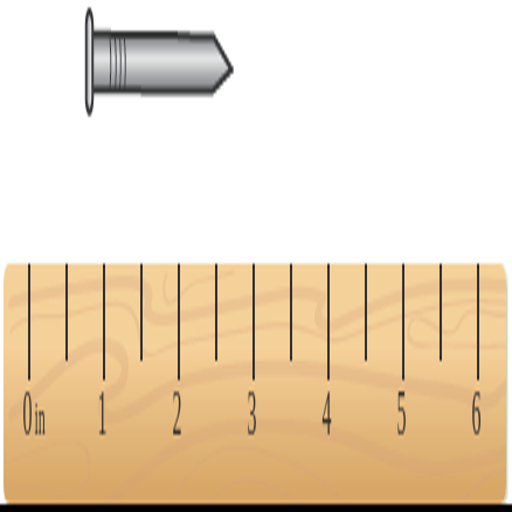

In [12]:
train_dataset[100]["image"]

<a name="Inference"></a>
### Inference
Now let's try the model on the hundredth sample of the train dataset without training.

In [13]:
image = train_dataset[100]["image"]
prompt = train_dataset[100]["prompt"]
prompt

[{'content': [{'text': None, 'type': 'image'},
   {'text': 'Move the ruler to measure the length of the nail to the nearest inch. The nail is about (_) inches long.. Also first provide your reasoning or working out on how you would go about solving the question between <REASONING> and </REASONING> and then your final answer between <SOLUTION> and (put a single float here) </SOLUTION>',
    'type': 'text'}],
  'role': 'user'}]

In [14]:
image = train_dataset[100]["image"]
structured_prompt = train_dataset[100]["prompt"]

# 1. Convert the structured prompt (list of dictionaries) into a single string
#    This will apply the chat template and embed image tokens (e.g., <|vision_start|>) into the string.
formatted_text_with_image_tokens = tokenizer.apply_chat_template(
    structured_prompt,
    tokenize=False, # We want the raw string output from the template
    add_generation_prompt=True, # Add the assistant turn start token if necessary
    return_tensors=None, # Ensure a string is returned
)

inputs = tokenizer(
    image,
    formatted_text_with_image_tokens, # Pass the formatted string containing image tokens
    add_special_tokens = False, # Let apply_chat_template handle special tokens
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.0, min_p = 0.1)

<REASONING>
To measure the length of the nail to the nearest inch, I need to determine how long the nail is by comparing it to the ruler.

Step 1: Identify the starting point of the nail.
The head of the nail (the circular part) is aligned with the 0-inch mark on the ruler.

Step 2: Identify the ending point of the nail.
The sharp tip of the nail extends past the 3-inch mark but does not reach the 4-inch mark.

Step 3: Determine the length to the nearest inch.
Since the tip is between 3 and 4 inches, and we are rounding to the nearest inch, I need to see which whole number it is closer to. The tip is clearly past 3 and before 4, so I need to estimate if it's closer to 3 or 4.

Looking at the visual: the tip appears to be just shy of the 4-inch mark. It’s about 3.5 inches long (since it’s roughly halfway between 3 and 4), but since we need to round to the nearest inch, 3.5 rounds up to 4. However, let’s be precise. The nail's tip looks to be at approximately 3.2 to 3.4 inches. Since thi

<a name="Train"></a>
### Train the model

Now set up the `GRPO` Trainer and all configurations! Note we actually enable `GSPO` as well!

In [17]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    logging_steps = 1,
    log_completions = False,
    per_device_train_batch_size = 16,
    gradient_accumulation_steps = 4, # Increase to 4 for smoother training
    num_generations = 2, # Decrease if out of memory
    max_prompt_length = 1024,
    max_completion_length = 1024,
    num_train_epochs = 0.5, # Set to 1 for a full training run
    # max_steps = 60,
    save_steps = 60,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
    # bf16=False,
    # fp16=True,

    # Below enables GSPO:
    importance_sampling_level = "sequence",
    mask_truncated_completions = False,
    loss_type = "dr_grpo",
)

And let's run the trainer! If you scroll up, you'll see a table of rewards. The goal is to see the `reward` column increase!

You might have to wait 150 to 200 steps for any action. You'll probably get 0 reward for the first 100 steps. Please be patient!

| Step | Training Loss | reward    | reward_std | completion_length | kl       |
|------|---------------|-----------|------------|-------------------|----------|
| 1    | 0.000000      | 0.125000  | 0.000000   | 200.000000        | 0.000000 |
| 2    | 0.000000      | 0.072375  | 0.248112   | 200.000000        | 0.000000 |
| 3    | 0.000000      | -0.079000 | 0.163776   | 182.500000        | 0.000005 |

During inference, you might encounter `addCriterion` or some weird gibberish outputs. Please read our [blog post](https://unsloth.ai/docs/new/vision-reinforcement-learning-vlm-rl#qwen-2.5-vl-vision-rl-issues-and-quirks) on why this occurs. It seems to be an inherent thing inside of the model, and we can ignore this.

In [18]:
trainer = GRPOTrainer(
    model = model,
    args = training_args,
    # Pass the processor to handle multimodal inputs
    processing_class = tokenizer,
    reward_funcs = [
        formatting_reward_func,
        correctness_reward_func,
    ],
    train_dataset = train_dataset,
)

trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 566 | Num Epochs = 1 | Total steps = 9
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 4 x 1) = 64
 "-____-"     Trainable parameters = 43,646,976 of 8,810,770,672 (0.50% trained)


-------------------- Question:
[{'content': [{'text': None, 'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7CBEECA01670>}, {'text': 'What is the highest value on the X axis?. Also first provide your reasoning or working out on how you would go about solving the question between <REASONING> and </REASONING> and then your final answer between <SOLUTION> and (put a single float here) </SOLUTION>', 'type': 'text'}], 'role': 'user'}] 
Answer:
30 
Response:<REASONING>
The question asks for the highest value on the X-axis of the provided graph.

1. I examine the X-axis, which is labeled "MICROGRAMS/ML-E-DNP-LYSINE-HCL".
2. I look at the numerical markings along this axis.
3. The axis begins at 0 and has labeled tick marks at 5, 10, 15, 20, 25, and 30.
4. The last labeled tick mark on the right side of the X-axis is 30.
5. There is no indication that the axis extends beyond 30.
6. Therefore, the highest value shown on the X-axis is 30.

Note: The gr

Step,Training Loss,reward,reward_std,train,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,tools / call_frequency,tools / failure_frequency,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,cispo_clip_ratio,rewards / formatting_reward_func / mean,rewards / formatting_reward_func / std,rewards / correctness_reward_func / mean,rewards / correctness_reward_func / std
1,0.015000,1.703125,0.154680,0,417.093750,115.000000,1024.000000,0.140625,317.781799,115.000000,772.000000,0,0,0,0,0,0,0,0.000000,0,1.703125,0.705527,0.000000,0.000000
2,0.000700,2.000000,0.088388,No Log,472.328125,114.000000,1024.000000,0.171875,357.830200,114.000000,958.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.656250,0.760508,0.343750,0.760508
3,0.012400,1.984375,0.110485,No Log,419.812500,132.000000,1024.000000,0.109375,345.614044,132.000000,949.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.796875,0.595744,0.187500,0.587570
4,0.006200,1.921875,0.110485,No Log,472.671875,118.000000,1024.000000,0.187500,345.442322,118.000000,804.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.609375,0.789156,0.312500,0.731925
5,0.016500,1.781250,0.132583,No Log,405.859375,116.000000,1024.000000,0.140625,304.709076,116.000000,882.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.718750,0.700765,0.062500,0.350736
6,0.021400,2.078125,0.154680,No Log,337.843750,95.000000,1024.000000,0.046875,304.098358,95.000000,822.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.890625,0.440677,0.187500,0.587570
7,0.025300,1.515625,0.243068,No Log,491.500000,111.000000,1024.000000,0.265625,298.893616,111.000000,842.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.484375,0.872729,0.031250,0.250000
8,0.032300,1.859375,0.243068,No Log,408.859375,130.000000,1024.000000,0.093750,345.224152,130.000000,899.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.765625,0.610547,0.093750,0.426084
9,0.029800,1.828125,0.154680,No Log,429.031250,126.000000,1024.000000,0.171875,305.547180,126.000000,975.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000000,No Log,1.640625,0.763600,0.187500,0.587570


-------------------- Question:
[{'content': [{'text': None, 'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7CBEECD1A5D0>}, {'text': 'Subtract all tiny purple shiny cubes. Subtract all large purple balls. How many objects are left?. Also first provide your reasoning or working out on how you would go about solving the question between <REASONING> and </REASONING> and then your final answer between <SOLUTION> and (put a single float here) </SOLUTION>', 'type': 'text'}], 'role': 'user'}] 
Answer:
9 
Response:<REASONING>
First, I need to identify all the objects in the image.

There are 10 objects in total:
1. A small gray cylinder (left side)
2. A large green cylinder (front center)
3. A large blue shiny cylinder (back left)
4. A large red shiny cylinder (center)
5. A small red shiny cylinder (back right, behind the yellow cube)
6. A large yellow cube (back right)
7. A cyan matte sphere (left center)
8. A purple matte sphere (back center)
9. A 

TrainOutput(global_step=9, training_loss=0.01775102089676592, metrics={'train_runtime': 1641.0609, 'train_samples_per_second': 0.172, 'train_steps_per_second': 0.005, 'total_flos': 0.0, 'train_loss': 0.01775102089676592})

<a name="Inference"></a>
### Inference

Let's run the model! You can modify the instruction and input.

In [21]:
image = train_dataset[100]["image"]
prompt = train_dataset[100]["prompt"]

formatted_text_with_image_tokens = tokenizer.apply_chat_template(
    prompt,
    tokenize=False, # We want the raw string output from the template
    add_generation_prompt=True, # Add the assistant turn start token if necessary
    return_tensors=None, # Ensure a string is returned
)

inputs = tokenizer(
    image,
    formatted_text_with_image_tokens,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.0, min_p = 0.1)

<REASONING>
To measure the length of the nail using the ruler, I need to determine the distance from the starting point (the head of the nail) to the ending point (the tip of the nail). 

- The head of the nail is aligned with the 0-inch mark on the ruler.
- The tip of the nail extends past the 3-inch mark but does not reach the 4-inch mark.
- Since the question asks for the length to the nearest inch, I need to round the actual measurement to the nearest whole number.
- The nail's length is between 3 and 4 inches. To the nearest inch, this rounds to 3 inches.

Therefore, the nail is about 3 inches long.
</REASONING>

<SOLUTION>
3.0</SOLUTION><|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, use Hugging Face’s `push_to_hub` for online saving, or `save_pretrained` for local storage.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [22]:
model.save_pretrained("grpo_lora")  # Local saving
tokenizer.save_pretrained("grpo_lora")
# model.push_to_hub("your_name/grpo_lora", token = "...") # Online saving
# processor.push_to_hub("your_name/grpo_lora", token = "...") # Online saving

[]

Verify LoRA is actually trained!

In [23]:
from safetensors import safe_open

tensors = {}
with safe_open("grpo_lora/adapter_model.safetensors", framework = "pt") as f:
    # Verify both A and B are non zero
    for key in f.keys():
        tensor = f.get_tensor(key)
        n_zeros = (tensor == 0).sum() / tensor.numel()
        assert(n_zeros.item() != tensor.numel())

<a name="Save"></a>
### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [24]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False:
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [25]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )

Special Credits to [GAD-Cell](https://github.com/GAD-cell) for helping Unsloth create this notebook and bringing VLM GRPO into Unsloth!
Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp.

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other resources:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
4. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://unsloth.ai/docs/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://unsloth.ai/docs/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>

  This notebook and all Unsloth notebooks are licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme)